<a href="https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/notebooks/gene_expression/Exercise_1_Gene_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gene Modulation Example

### *Ted Natoli*


The goal of this notebook is to illustrate basic usage of I/O functionality in the [`cmapR`](https://github.com/workshop/data/cmapR) package. As a case study, we'll be analyzing signatures of compounds that do and do not modulate the gene MYC.



## Setup

Here we'll install the packages required for this notebook, most notably `cmapR`. Please note that this can take a while, as all the package dependencies will be installed as well.

In [ ]:
# install required packages
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("cmapR")



Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'cmapR'

Warning message:
“dependency ‘prada’ is not available”
also installing the dependencies ‘XVector’, ‘RCurl’, ‘Rhdf5lib’, ‘rhdf5filters’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘Biobase’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘DelayedArray’, ‘rhdf5’, ‘data.table’, ‘SummarizedExperiment’, ‘matrixStats’


Warning message in install.packages(...):
“installation of package ‘RCurl’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘Rhdf5lib’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘BiocGenerics’ had non-zero exit status”


In [ ]:
# load cmapR library
library(cmapR)

# load data.table for fast reading of text files
library(data.table)

# load pheatmap for plotting heatmaps
library(pheatmap)

# for controlling figure sizes
library(repr)

Set up paths for matrix and metadata. In this case, we'll be using the current public release of CMap L1000 data, found at [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742), and made accessible locally on this Jupyter server.

In [ ]:
ds_path <- "/srv/data/workshop/data/common/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx"
siginfo_path <- "/srv/data/workshop/data/common/GSE92742_Broad_LINCS_sig_info.txt"
sig_metrics_path <- "/srv/data/workshop/data/common/GSE92742_Broad_LINCS_sig_metrics.txt"
geneinfo_path <- "/srv/data/workshop/data/common/GSE92742_Broad_LINCS_gene_info.txt"

## Slicing

Load the metadata for all CMap signatures. We're doing this because we don't want to load all signatures at once. The matrix is too large. So instead, we'll figure out the specific set of signatures beforehand and then extract only those. To do this we need both the sig_info and sig_metrics files, both of which are contained in [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742).

In [ ]:
# suppressing warnings so that we don't have to see
# fread complain about inconsistencies in some of the
# metadata columns
siginfo <- suppressWarnings(data.table::fread(siginfo_path))
sigmetrics <- suppressWarnings(data.table::fread(sig_metrics_path))

In [ ]:
str(siginfo)

Classes ‘data.table’ and 'data.frame':	473647 obs. of  12 variables:
 $ sig_id        : chr  "AML001_CD34_24H:A05" "AML001_CD34_24H:A06" "AML001_CD34_24H:B05" "AML001_CD34_24H:B06" ...
 $ pert_id       : chr  "DMSO" "DMSO" "DMSO" "DMSO" ...
 $ pert_iname    : chr  "DMSO" "DMSO" "DMSO" "DMSO" ...
 $ pert_type     : chr  "ctl_vehicle" "ctl_vehicle" "ctl_vehicle" "ctl_vehicle" ...
 $ cell_id       : chr  "CD34" "CD34" "CD34" "CD34" ...
 $ pert_dose     : chr  "0.1" "0.1" "0.1" "0.1" ...
 $ pert_dose_unit: chr  "%" "%" "%" "%" ...
 $ pert_idose    : chr  "0.1 %" "0.1 %" "0.1 %" "0.1 %" ...
 $ pert_time     : int  24 24 24 24 24 24 24 24 24 24 ...
 $ pert_time_unit: chr  "h" "h" "h" "h" ...
 $ pert_itime    : chr  "24 h" "24 h" "24 h" "24 h" ...
 $ distil_id     : chr  "AML001_CD34_24H_X1_F1B10:A05" "AML001_CD34_24H_X3_F1B10:A06" "AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X3_F1B10:B05" "AML001_CD34_24H_X3_F1B10:B06" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [ ]:
str(sigmetrics)

Classes ‘data.table’ and 'data.frame':	473647 obs. of  12 variables:
 $ sig_id                : chr  "AML001_CD34_24H:A05" "AML001_CD34_24H:A06" "AML001_CD34_24H:B05" "AML001_CD34_24H:B06" ...
 $ pert_id               : chr  "DMSO" "DMSO" "DMSO" "DMSO" ...
 $ pert_iname            : chr  "DMSO" "DMSO" "DMSO" "DMSO" ...
 $ pert_type             : chr  "ctl_vehicle" "ctl_vehicle" "ctl_vehicle" "ctl_vehicle" ...
 $ distil_cc_q75         : num  -666 -666 0.16 -666 0.4 0 0.16 0 0.65 -666 ...
 $ distil_ss             : num  4.79 3.87 2.71 3.52 3.02 ...
 $ ngenes_modulated_up_lm: int  35 19 13 11 8 23 4 4 196 259 ...
 $ ngenes_modulated_dn_lm: int  63 33 13 24 15 23 10 9 208 239 ...
 $ tas                   : num  0.01001 0.00729 0.08953 0.00598 0.16677 ...
 $ pct_self_rank_q25     : num  -666 -666 9.06 -666 4.97 ...
 $ is_exemplar           : int  0 0 0 1 0 0 0 0 0 0 ...
 $ distil_nsample        : int  1 1 2 1 2 2 2 2 2 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [ ]:
# we'll want to add the cell_id column to the sig_metrics data.table,
# making sure it's in the right order
index <- match(sigmetrics$sig_id, siginfo$sig_id)
sigmetrics$cell_id <- siginfo$cell_id[index]

And for genes

In [ ]:
geneinfo <- data.table::fread(geneinfo_path)

In [ ]:
str(geneinfo)

Classes ‘data.table’ and 'data.frame':	12328 obs. of  5 variables:
 $ pr_gene_id    : int  780 7849 2978 2049 2101 8717 10594 826 11224 6158 ...
 $ pr_gene_symbol: chr  "DDR1" "PAX8" "GUCA1A" "EPHB3" ...
 $ pr_gene_title : chr  "discoidin domain receptor tyrosine kinase 1" "paired box 8" "guanylate cyclase activator 1A" "EPH receptor B3" ...
 $ pr_is_lm      : int  1 1 0 0 0 0 0 0 0 0 ...
 $ pr_is_bing    : int  1 1 0 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Designate my gene of interest using its gene symbol.



In [ ]:
my_gene <- "MYC"

Look up the corresponding gene_id, since this will correspond to row ids in the data matrix.

In [ ]:
my_gene_id <- geneinfo[pr_gene_symbol==my_gene]$pr_gene_id

Figure out list of signature ids (sig_ids) corresponding to compounds in the cell line A375, where the given signature had exactly 3 replicates. This is somewhat arbitrary but useful in reducing the number of signatures we're dealing with.

In [ ]:
sigs_of_interest <- sigmetrics[pert_type=="trt_cp" &
                  cell_id=="A375" & 
                  distil_nsample==3]
sig_ids <- sigs_of_interest$sig_id

How many did we get?

In [ ]:
length(sig_ids)

[1] 7020

Now slice out the corresponding rows and columns from the data matrix using `parse.gctx`, which will return an object of class GCT. Make sure to cast the gene_id as a character so it's not mistakenly interpreted as an integer index.

In [ ]:
ds <- cmapR::parse.gctx(ds_path,
                        rid=as.character(my_gene_id),
                        cid=sig_ids)

reading /srv/data/workshop/data/common/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
done


Let's take a look at the structure of the object we can do this by simply typing its name.

In [ ]:
ds

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1, 1:7020] 0.0869 -0.5384 -0.6922 0.5781 1.0301 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr "4609"
  .. .. ..$ : chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ rid    : chr "4609"
  ..@ cid    : chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ rdesc  :'data.frame':	1 obs. of  1 variable:
  .. ..$ id: chr "4609"
  ..@ cdesc  :'data.frame':	7020 obs. of  1 variable:
  .. ..$ id: chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ version: chr(0) 
  ..@ src    : chr "/srv/da

Note that the matrix only has one row, because we only requested data for a single gene.

## Analysis

We're interested in the data matrix, located in the slot `@mat`. Let's look at the distribution of z-scores. We'll add some vertical lines to indicate the thresholds for modulation.

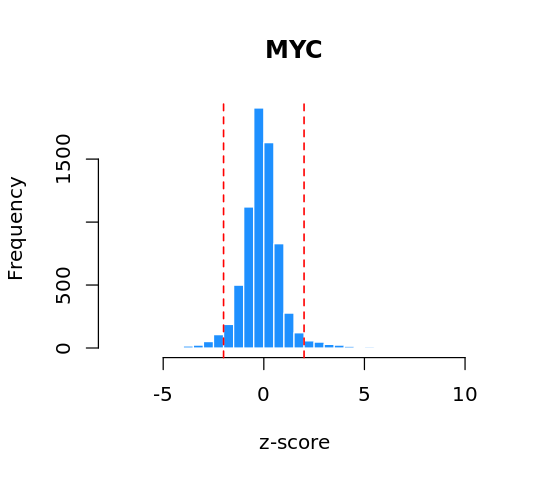

In [ ]:
options(repr.plot.width=4.5, repr.plot.height=4)
hist(ds@mat, col="dodgerblue", border="white", breaks=30, main=my_gene, xlab="z-score")
abline(v=2, lty=2, col=2, lwd=1.3)
abline(v=-2, lty=2, col=2, lwd=1.3)

Lets identify the signatures in which the gene was significantly modulated.

In [ ]:
mod_idx <- which(abs(ds@mat[1, ]) > 2)

How many are there?

In [ ]:
length(mod_idx)

[1] 451

Let's compare these signatures to each other to see whether they have any similarity. For comparison, we'll include roughly the same number of signatures in which the gene was **NOT** modulated.

In [ ]:
non_mod_idx <- which(abs(ds@mat[1, ]) < 0.06)
length(non_mod_idx)

[1] 456

Good, this is roughly an equal number. Slice out the signatures from the matrix, restricting to landmark space (i.e. directly measured genes only).

In [ ]:
lm_ids <- as.character(geneinfo[pr_is_lm==1]$pr_gene_id)
ds2 <- parse.gctx(ds_path, rid=lm_ids,
                  cid=c(names(mod_idx), names(non_mod_idx)))


reading /srv/data/workshop/data/common/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
done


Compute all pairwise correlations between signatures.

In [ ]:
corr <- cor(ds2@mat, method="spearman")

Cluster the correlations, overlaying a color bar indicating the degree of modulation of our gene of interest.

In [ ]:
mod_df <- data.frame(abs_zscore=abs(ds@mat[, c(mod_idx, non_mod_idx)]))
rownames(mod_df) <- c(names(mod_idx), names(non_mod_idx))

Plot as a heatmap using the `pheatmap` package.

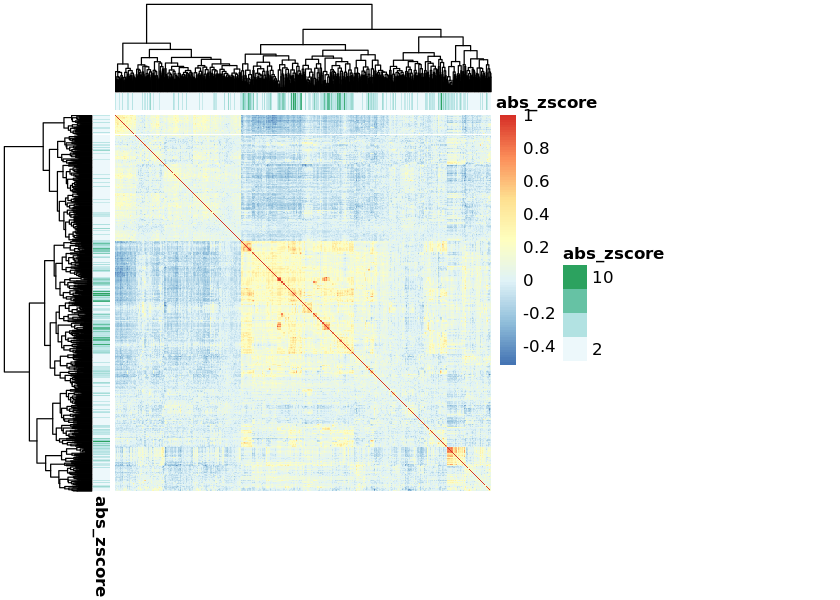

In [ ]:
options(repr.plot.width=7, repr.plot.height=5)
pheatmap::pheatmap(corr, annotation_row=mod_df, annotation_col=mod_df,
                  show_rownames=F, show_colnames=F)

Seems like we do see ~2 clusters which roughly correspond to the signatures in which our gene is modulated, as indicated by the color bar on the margins. Not perfect but definitely a trend.

Do the signatures that modulate MYC do so specifically? Let's look at the number of genes modulated in each class.

In [ ]:
sigmetrics[, distil_ss_ngene := ngenes_modulated_up_lm + ngenes_modulated_up_lm, .(sig_id)]

In [ ]:
ss_list <- list(
    mod = sigmetrics[sig_id %in% names(mod_idx)]$distil_ss_ngene,
    non_mod = sigmetrics[sig_id %in% names(non_mod_idx)]$distil_ss_ngene
)

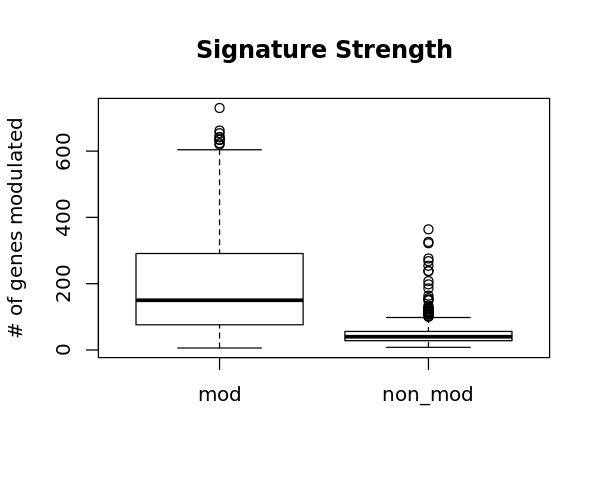

In [ ]:
options(repr.plot.width=5, repr.plot.height=4)
boxplot(ss_list, main="Signature Strength",  ylab="# of genes modulated")

In general those compounds that modulate MYC tend to modulate lots of genes, but there are a few that are more selective. Let's look at those.

In [ ]:
sigmetrics[sig_id %in% names(mod_idx) &
          distil_ss_ngene <= 30,
          .(sig_id, pert_id, pert_iname, distil_ss_ngene)][
    order(distil_ss_ngene, decreasing=F)]

sig_id,pert_id,pert_iname,distil_ss_ngene
DOS054_A375_24H:BRD-K75117691-001-01-9:5,BRD-K75117691,BRD-K75117691,6
CPC011_A375_6H:BRD-K81169441-236-06-6:10,BRD-K81169441,cerivastatin,20
DOS054_A375_24H:BRD-K24896023-001-01-9:5,BRD-K24896023,BRD-K24896023,20
CPC011_A375_6H:BRD-K94441233-001-09-8:10,BRD-K94441233,mevastatin,22
DOS049_A375_24H:BRD-K99182933-001-01-3:5,BRD-K99182933,BRD-K99182933,22
DOS054_A375_24H:BRD-K62771975-001-01-5:5,BRD-K62771975,BRD-K62771975,22
DOS054_A375_24H:BRD-K92800455-001-01-5:5,BRD-K92800455,BRD-K92800455,22
CPC017_A375_6H:BRD-A11609859-303-01-2:10,BRD-A11609859,SB-205607,24
CPC017_A375_6H:BRD-K09638361-001-01-4:10,BRD-K09638361,IC-261,24
CPC004_A375_6H:BRD-A64977602-001-04-3:10,BRD-A64977602,mirtazapine,26


Looks like there are a few statins at the top of the list. Let's see which direction they regulate MYC. [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491823/) suggests that perhaps statins up-regulate a specific microRNA that reduces MYC expression, albeit in a very different cell type.

In [ ]:
statin_sigs <- c("CPC011_A375_6H:BRD-K81169441-236-06-6:10",
                "CPC011_A375_6H:BRD-K94441233-001-09-8:10",
                "CPC004_A375_6H:BRD-K22134346-001-11-6:10")
round(ds@mat[, statin_sigs], 2)

CPC011_A375_6H:BRD-K81169441-236-06-6:10 
                                   -2.55 
CPC011_A375_6H:BRD-K94441233-001-09-8:10 
                                   -2.27 
CPC004_A375_6H:BRD-K22134346-001-11-6:10 
                                   -2.44

Indeed these statins down-regulate MYC, which may be in agreement with the finding in the paper above.